In [29]:
import pymc3 as pmc
import os
import json
import scipy
import requests
import pickle
import bokeh

import sklearn as sk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from bokeh.plotting import ColumnDataSource, figure
from bokeh.io import output_file, show, output_notebook
from bokeh.models.tools import HoverTool
from bokeh.models import Span

pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [14]:
with open(Path('..') / '..' / 'data' / 'clustered.pkl', 'rb') as file:
    clustered = pickle.load(file)
    
with open(Path('..') / '..' / 'data' / 'control.pkl', 'rb') as file:
    control = pickle.load(file)

In [30]:
%matplotlib inline
def histogram(iterable):
    """Make a histogram using NumPy"""
    hist, bins = np.histogram(iterable, bins=10)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.show()

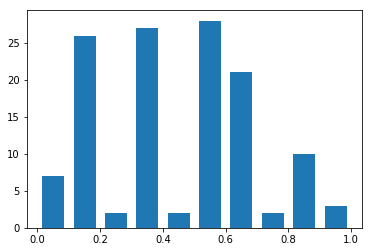

In [31]:
histogram(list(map(np.mean, clustered)))

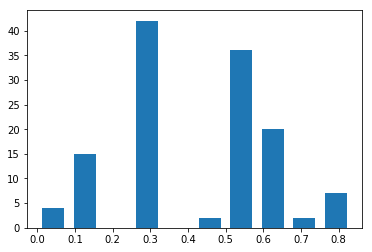

In [32]:
histogram(list(map(np.mean, control)))

In [34]:
observed = list(map(np.mean, clustered))
controlled = list(map(np.mean, control))

with pmc.Model() as control_model:
    sd_1 = pmc.Uniform('sd_1', lower=0, upper=1)
    sd_2 = pmc.Uniform('sd_2', lower=0, upper=1)
    μ_1 = pmc.Normal('μ_1', 
                    mu=np.mean(list(map(np.mean, clustered + control))),
                    sd=2 * np.std(list(map(np.mean, clustered + control)))
                   )
    μ_2 = pmc.Normal('μ_2', 
                    mu=np.mean(list(map(np.mean, clustered + control))),
                    sd=2 * np.std(list(map(np.mean, clustered + control)))
                   )
    
    obs_means_1 = pmc.Normal('obs_means_1', mu=μ_1, sd=sd_1, 
                             observed=observed)
    obs_means_2 = pmc.Normal('obs_means_2', mu=μ_2, sd=sd_2,
                             observed=controlled)
    
    diff_of_sds = pmc.Deterministic('Diff_of_sds', sd_2 - sd_1)
    
map_estimate = pmc.find_MAP(model=control_model)

with control_model:
    start = map_estimate
    
    step = pmc.Metropolis()
    
    control_trace = pmc.sample(50_000, step=step, start=start)

logp = 26.414, ||grad|| = 20.214: 100%|██████████| 17/17 [00:00<00:00, 1644.90it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [μ_2]
>Metropolis: [μ_1]
>Metropolis: [sd_2]
>Metropolis: [sd_1]
Sampling 4 chains: 100%|██████████| 202000/202000 [01:00<00:00, 3332.27draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [35]:
tr = control_trace[40_000:]  # Burn in a log ways
trace_df = pmc.trace_to_dataframe(tr).tail(10_000)


In [41]:
TOOLS="pan,wheel_zoom,box_zoom,reset"
p1 = figure( title = 'Comparing sd-observed and θ-control', tools=TOOLS )
 
colors = ['cornflowerblue', 'coral']
legends = ['sd-observed', 'sd-control']
 
output_notebook()
 
for i, column in enumerate(['sd_1', 'sd_2']):
 
    hist, edges = np.histogram(trace_df[column].values, bins=50, density=False)
    data_values = trace_df[column].tolist()
    source = ColumnDataSource(data = dict(data_value=hist, 
                                               data_cum_value= 1 - (np.cumsum(hist) / np.sum(hist)),
                                               edges=edges))
 
    p1.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
            fill_color=colors[i], line_color="#033649", alpha=0.5, legend=legends[i])

show(p1)

Loading BokehJS ...

/Users/zach_anglin/anaconda3/envs/py36/lib/python3.6/site-packages/bokeh/models/sources.py:110: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('data_cum_value', 50), ('data_value', 50), ('edges', 51)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))
/Users/zach_anglin/anaconda3/envs/py36/lib/python3.6/site-packages/bokeh/models/sources.py:110: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('data_cum_value', 50), ('data_value', 50), ('edges', 51)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))


We can easily get a credible interval here -- just take the percentage of observations in which the observed SD is greater than the control.

In [44]:
sum(trace_df['Diff_of_sds'] < 0) /  len(trace_df)

0.9912

So, we are virtually certain that these distributions are fundamentally different. The multigraph-based grouping strategy pulls out clusters that are significantly more grouped among themselves than a control.